In [1]:
import os; os.chdir(os.path.join('..', '..', '..'))
print(os.getcwd())

/home/eharkin/projects/5HTGIF-dev


In [2]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import pandas as pd
from scipy import stats

# Load data

In [3]:
MODEL_PATH = os.path.join('data', 'models')
BENCHMARK_PATH = os.path.join('data', 'processed', 'benchmarks')
SER_EXPT_PATH = os.path.join('data', 'processed', '5HT_fastnoise')
GABA_EXPT_PATH = os.path.join('data', 'processed', 'GABA_fastnoise')

benchmarks = {}
with open(os.path.join(BENCHMARK_PATH, 'sergifs_benchmark.dat'), 'rb') as f:
    benchmarks['sergif'] = pickle.load(f)
    f.close()

with open(os.path.join(BENCHMARK_PATH, 'gabagifs_benchmark.dat'), 'rb') as f:
    benchmarks['gabagif'] = pickle.load(f)
    f.close()

models = {}
with open(os.path.join(MODEL_PATH, '5HT', 'sergifs.lmod'), 'rb') as f:
    models['sergif'] = pickle.load(f)
    f.close()

with open(os.path.join(MODEL_PATH, 'GABA', 'gaba_gifs.mod'), 'rb') as f:
    models['gabagif'] = pickle.load(f)
    f.close()

experiments = {}
with open(os.path.join(SER_EXPT_PATH, '5HT_goodcells.ldat'), 'rb') as f:
    experiments['ser'] = pickle.load(f)
    f.close()

with open(os.path.join(GABA_EXPT_PATH, 'gaba_goodcells.ldat'), 'rb') as f:
    experiments['gaba'] = pickle.load(f)
    f.close()

# Benchmarks

- $M_d^*$ comparison
- $R^2$ comparison

In [4]:
md_dframe = pd.DataFrame({
    'Cell type': np.concatenate(
        [['5HT'] * len(benchmarks['sergif']['Md_vals']), ['GABA'] * len(benchmarks['gabagif']['Md_vals'])],
        axis=-1
    ),
    'Md': np.concatenate([benchmarks['sergif']['Md_vals'], benchmarks['gabagif']['Md_vals']], axis=-1),
    'R2': np.concatenate([[mod.var_explained_V for mod in models['sergif']], 
                          [mod.var_explained_V for mod in models['gabagif']]])
})
md_dframe

,Cell type,Md,R2
0,5HT,0.178631,0.956392
1,5HT,0.478057,0.944875
2,5HT,0.178443,0.927101
3,5HT,0.379274,0.930922
4,5HT,0.634222,0.925727
5,5HT,0.341966,0.875162
6,5HT,0.315841,0.906564
7,5HT,0.282449,0.916113
8,5HT,0.344348,0.965354
9,5HT,0.391585,0.951397


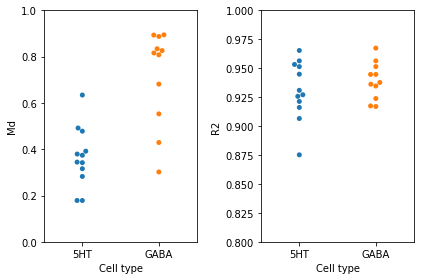

In [5]:
plt.figure()

plt.subplot(121)
plt.ylim(0, 1)
sns.swarmplot(x='Cell type', y='Md', data=md_dframe)

plt.subplot(122)
plt.ylim(0.8, 1)
sns.swarmplot(x='Cell type', y='R2', data=md_dframe)

plt.tight_layout()
plt.show()

In [6]:
print('Md difference')
print(stats.mannwhitneyu(
    md_dframe['Md'][md_dframe['Cell type'] == '5HT'],
    md_dframe['Md'][md_dframe['Cell type'] == 'GABA']
))
print('R2 difference')
print(stats.mannwhitneyu(
    md_dframe['R2'][md_dframe['Cell type'] == '5HT'],
    md_dframe['R2'][md_dframe['Cell type'] == 'GABA']
))

Md difference
MannwhitneyuResult(statistic=13.0, pvalue=0.0006164625591723975)
R2 difference
MannwhitneyuResult(statistic=56.0, pvalue=0.2793799114354468)


# Sample traces

/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


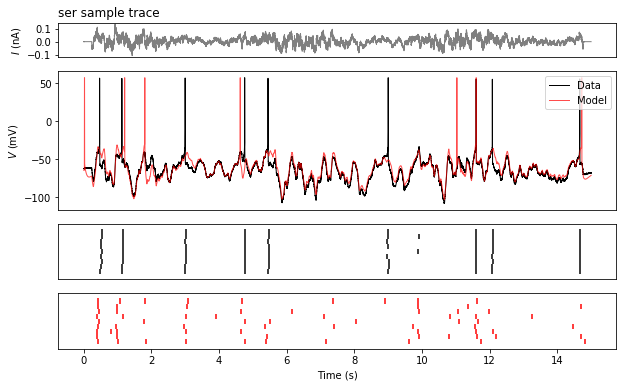

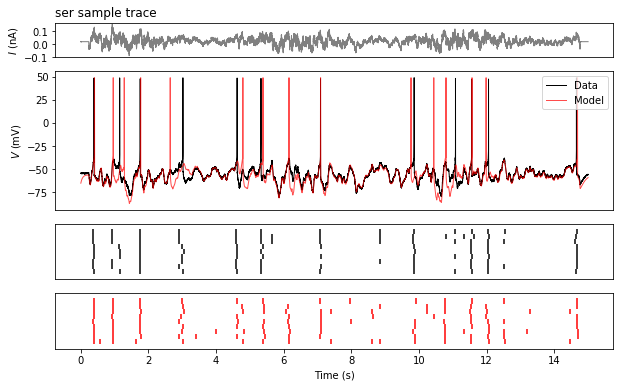

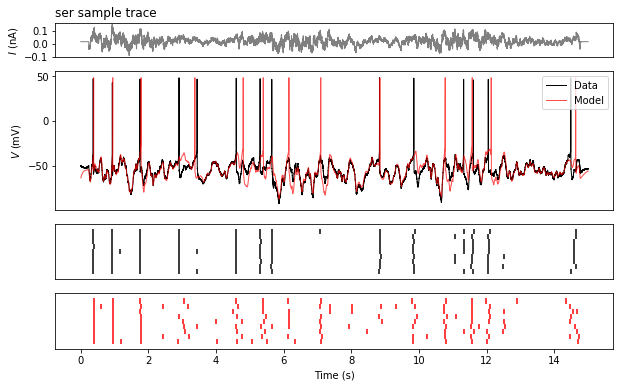

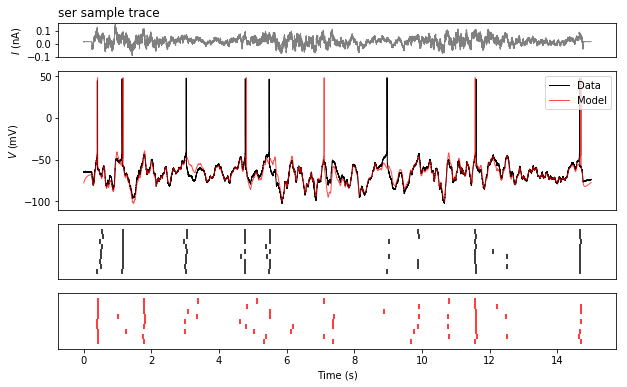

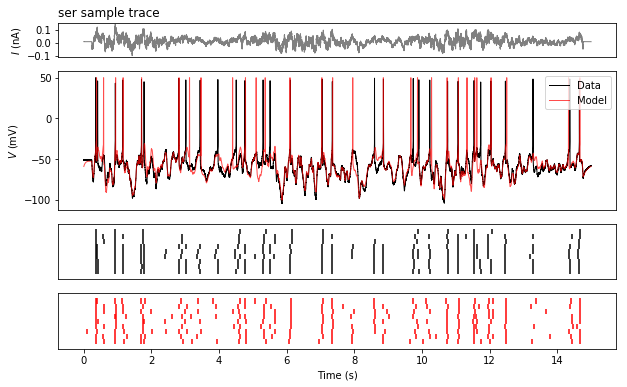

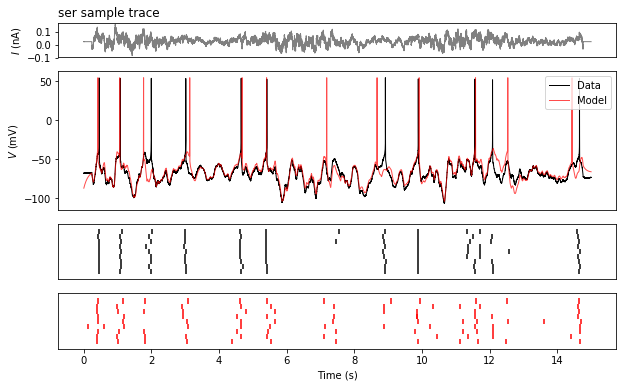

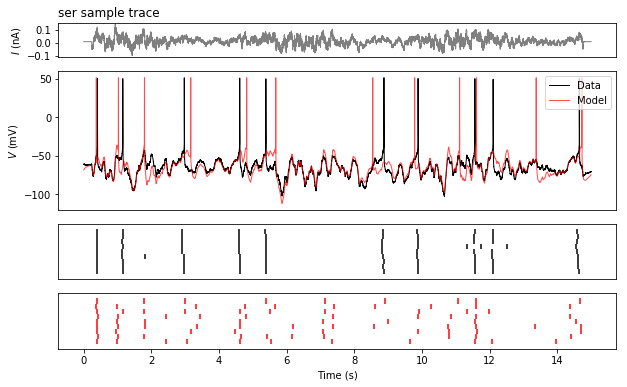

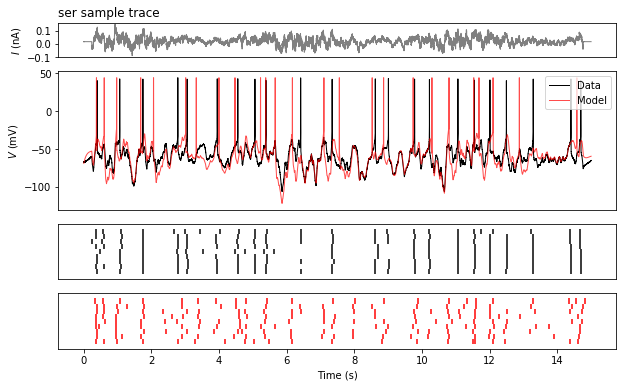

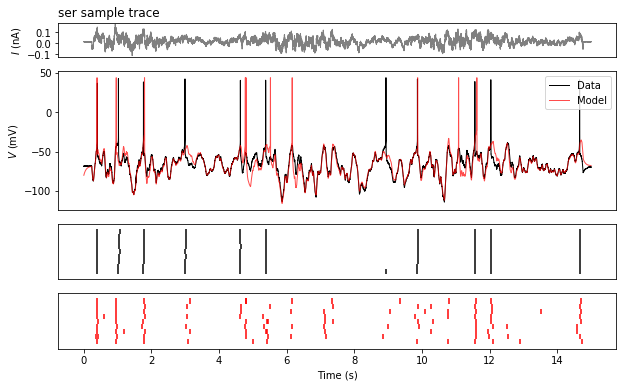

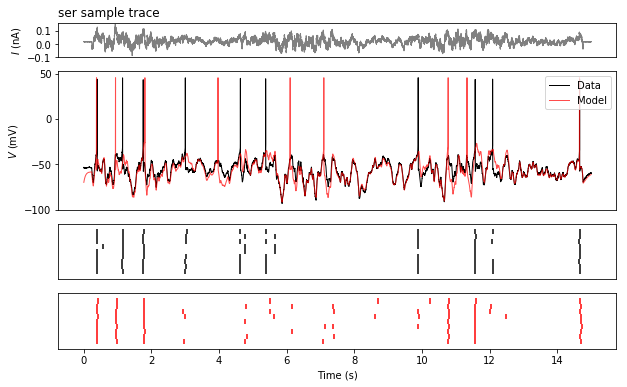

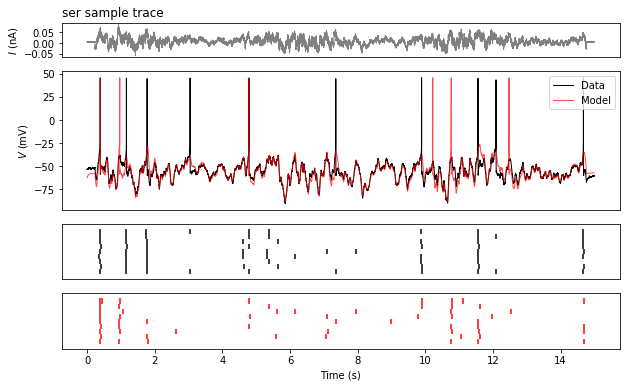

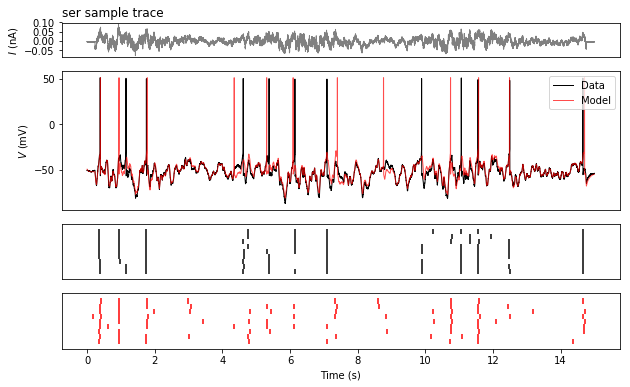

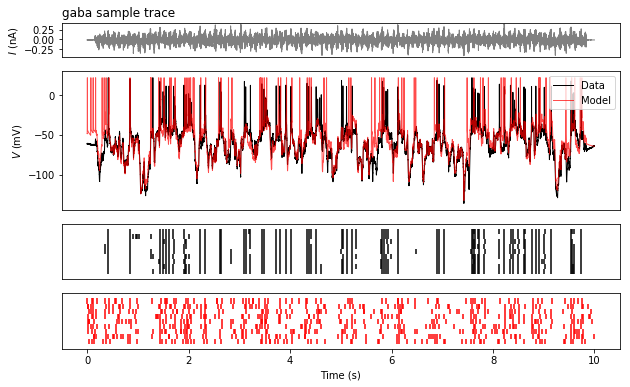

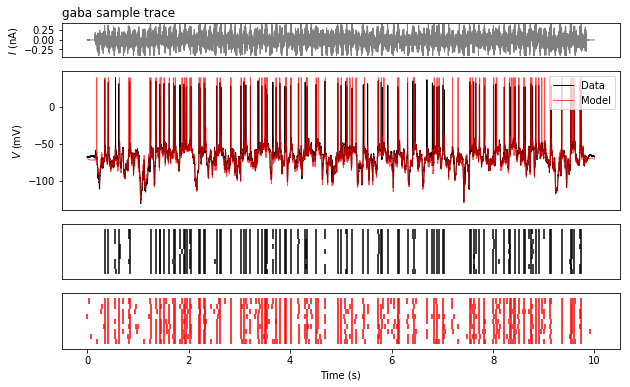

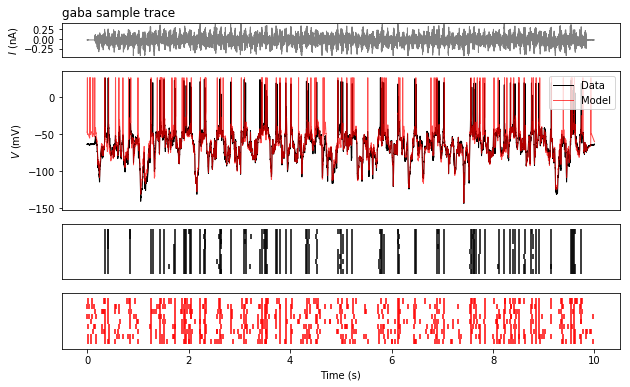

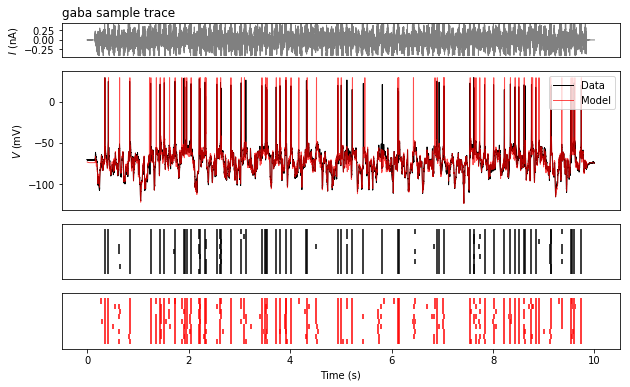

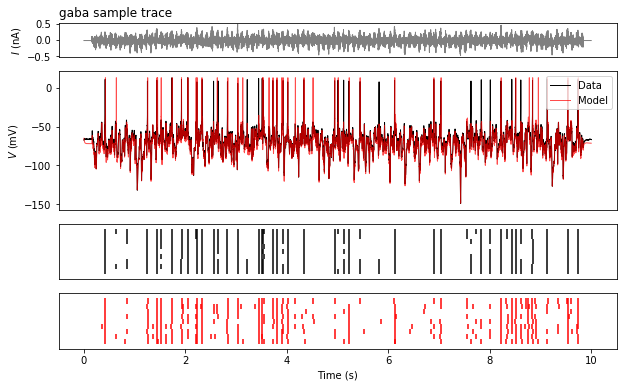

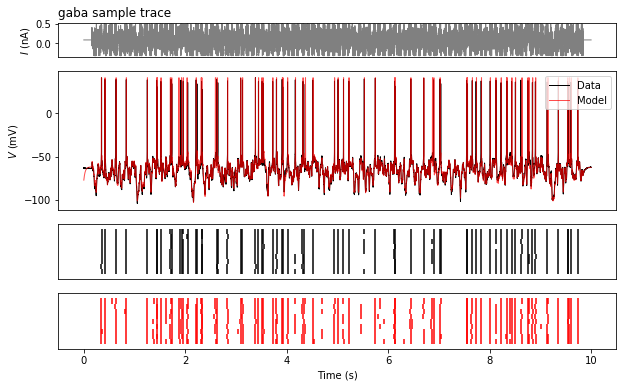

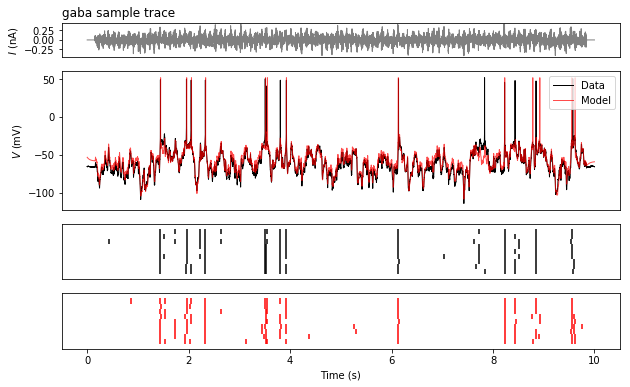

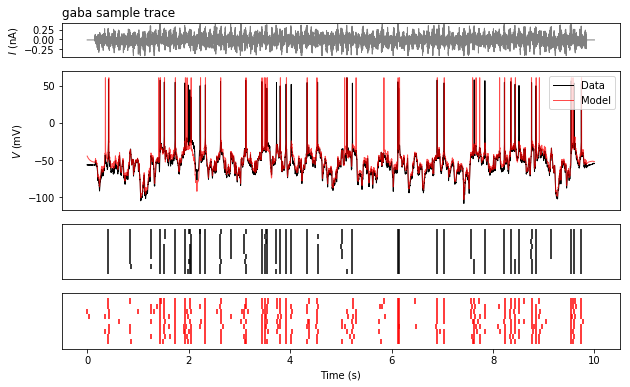

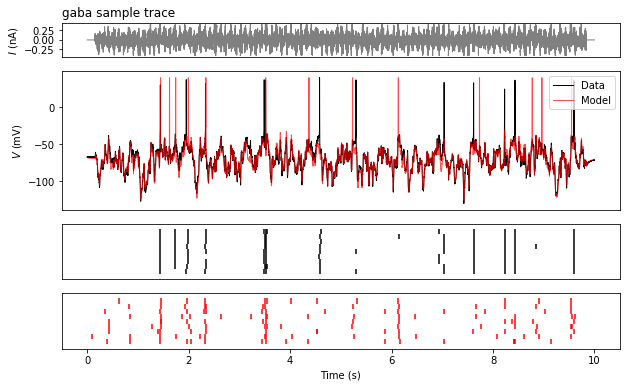

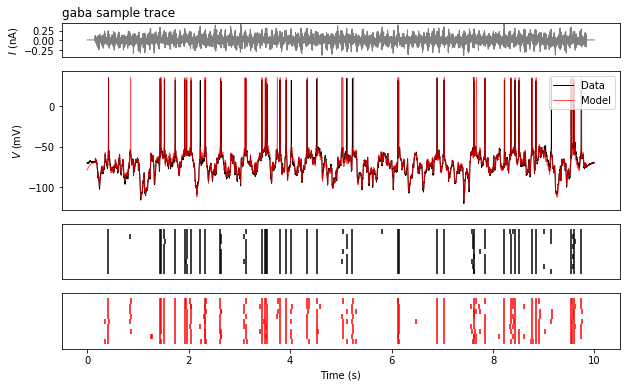

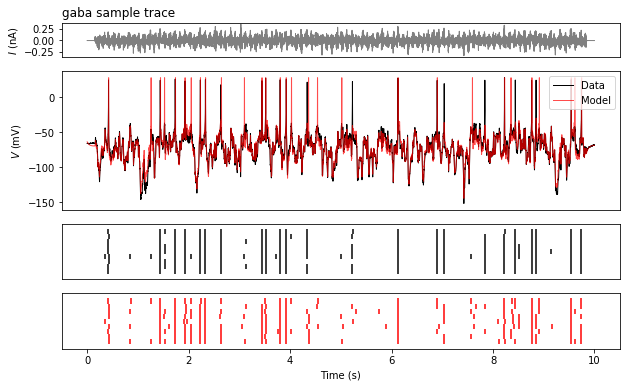

In [7]:
spec_sample = gs.GridSpec(4, 1, height_ratios=[0.25, 1, 0.4, 0.4])

for cell_type in experiments:
    for i in range(len(models['{}gif'.format(cell_type)])):
        
        plt.figure(figsize = (10, 6))

        plt.subplot(spec_sample[0, :])
        plt.title('{} sample trace'.format(cell_type), loc = 'left')
        plt.plot(
            experiments[cell_type][i].testset_traces[0].getTime() * 1e-3,
            experiments[cell_type][i].testset_traces[0].I,
            color = 'gray', lw = 1.
        )
        plt.xticks([])
        tmp_xlim = plt.xlim()
        plt.ylabel('$I$ (nA)')

        plt.subplot(spec_sample[1, 0])
        plt.plot(
            experiments[cell_type][i].testset_traces[0].getTime() * 1e-3,
            experiments[cell_type][i].testset_traces[0].V,
            color = 'k', lw = 1., label = 'Data'
        )
        assert experiments[cell_type][i].name == models['{}gif'.format(cell_type)][i].name
        t, V, _, _, spks = models['{}gif'.format(cell_type)][i].simulate(
            experiments[cell_type][i].testset_traces[0].I,
            models['{}gif'.format(cell_type)][i].El
        )
        V[np.isclose(V, 0)] = np.max(experiments[cell_type][i].testset_traces[0].V)
        plt.plot(
            t * 1e-3, V, 'r-', lw = 1, alpha = 0.7, label = 'Model'
        )
        plt.xticks([])
        plt.ylabel('$V$ (mV)')
        plt.legend(loc = 'upper right')

        plt.subplot(spec_sample[2, 0])
        data_spks = []
        for tr in experiments[cell_type][i].testset_traces:
            data_spks.append(tr.getSpikeTimes() * 1e-3)
        plt.eventplot(data_spks, color = 'k')
        plt.xticks([])
        plt.yticks([])
        plt.xlim(tmp_xlim)

        plt.subplot(spec_sample[3, 0])
        model_spks = []
        for j in range(len(experiments[cell_type][i].testset_traces)):
            model_spks.append(models['{}gif'.format(cell_type)][i].simulate(
                experiments[cell_type][i].testset_traces[0].I,
                models['{}gif'.format(cell_type)][i].El
            )[-1] * 1e-3)
        plt.eventplot(model_spks, color = 'r')
        plt.yticks([])
        plt.xlabel('Time (s)')
        plt.xlim(tmp_xlim)

del tmp_xlim